# Quarterback Passing Yards/Game Predictive Modeling

## Importing Passer Data

In [34]:
# Import dependencies
# NFL pbp data
import nfl_data_py as nfl

# Basics / visualizations
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

# Machine learning tools
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)


In [35]:
# Select only the relevant columns
columns = ['passer_player_name', 'posteam', 'defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards', 
           'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
           'passing_yards', 'cpoe', 'roof', 'surface']

# Loading in the NFL pbp data
data = nfl.import_pbp_data(range(2014,2025), columns, include_participation=False)

# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
data = data[columns]

# Drop all rows that are not a pass
data = data[data['play_type'] == 'pass']

# Drop the play type column
passer_data = data.drop(columns=['play_type'])

2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
2023 done.
2024 done.
Downcasting floats.


## Passer Preprocessing & Feature Engineering

In [42]:
# Group the data together by passer, week, season and aggregate
passer_df = passer_data.groupby(['passer_player_name', 'week', 'season'], as_index=False).agg(
    {'posteam' : 'first',
     'defteam' : 'first',
     'home_team' : 'first',
     'away_team' : 'first',
     'air_yards' : 'sum',
     'yards_after_catch' : 'sum',
     'epa' : 'sum',
     'complete_pass' : 'sum',
     'incomplete_pass' : 'sum',
     'interception' : 'sum',
     'qb_hit' : 'sum',
     'sack' : 'sum',
     'pass_touchdown' : 'sum',
     'passing_yards' : 'sum',
     'cpoe' : 'mean',
     'roof' : 'first',
     'surface' : 'first'
     }
)

In [43]:
# Create a new column that is completion percentage
passer_df['completion_percentage'] = passer_df['complete_pass'] / (passer_df['complete_pass'] + passer_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
passer_df['pass_attempts'] = passer_df['complete_pass'] + passer_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
passer_df = passer_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [44]:
# Create a new column that equals 1 if the passer is the home team and 0 if the passer is the away team
passer_df['home_flag'] = passer_df['home_team'] == passer_df['posteam']

# Drop the home_team and away_team columns
passer_df = passer_df.drop(columns=['home_team', 'away_team'])

In [45]:
# Reorder the columns
passer_df = passer_df[['passer_player_name', 'posteam', 'defteam', 'season', 'week', 'passing_yards', 'home_flag', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                        'cpoe', 'roof', 'surface']]

In [46]:
# Calculate the exponentially weighted moving average for each feature
passer_df['completion_percentage_ewma'] = passer_df.groupby('passer_player_name')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['pass_attempts_ewma'] = passer_df.groupby('passer_player_name')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['air_yards_ewma'] = passer_df.groupby('passer_player_name')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['yards_after_catch_ewma'] = passer_df.groupby('passer_player_name')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['epa_ewma'] = passer_df.groupby('passer_player_name')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['interception_ewma'] = passer_df.groupby('passer_player_name')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['qb_hit_ewma'] = passer_df.groupby('passer_player_name')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['sack_ewma'] = passer_df.groupby('passer_player_name')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['pass_touchdown_ewma'] = passer_df.groupby('passer_player_name')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['passing_yards_ewma'] = passer_df.groupby('passer_player_name')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

passer_df['cpoe_ewma'] = passer_df.groupby('passer_player_name')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

In [47]:
# Drop the non-ewma columns
passer_df = passer_df.drop(columns=['completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'cpoe'])

## Defense Preprocessing & Feature Engineering

In [56]:
# Select only the relevant columns
defense_columns = ['defteam', 'season', 'week', 'home_team', 'away_team', 'play_type', 'air_yards',
                   'yards_after_catch', 'epa', 'complete_pass', 'incomplete_pass', 'interception', 'qb_hit', 'sack', 'pass_touchdown',
                   'passing_yards', 'cpoe', 'roof', 'surface']


# nfl-data-py still loads other columns, so we again need to set our data equal to only the columns we want
defense_data = data[defense_columns]

# Drop the play type column
defense_data = defense_data.drop(columns=['play_type'])

In [57]:
# Group the data together by passer, week, season and aggregate
defense_df = defense_data.groupby(['defteam', 'week', 'season'], as_index=False).agg(
    {'home_team': 'first',
     'away_team': 'first',
     'air_yards': 'sum',
     'yards_after_catch': 'sum',
     'epa': 'sum',
     'complete_pass': 'sum',
     'incomplete_pass': 'sum',
     'interception': 'sum',
     'qb_hit': 'sum',
     'sack': 'sum',
     'pass_touchdown': 'sum',
     'passing_yards': 'sum',
     'cpoe': 'mean',
     'roof': 'first',
     'surface': 'first'
     }
)

In [58]:
# Create a new column that is completion percentage
defense_df['completion_percentage'] = defense_df['complete_pass'] / (defense_df['complete_pass'] + defense_df['incomplete_pass'])

# Create a new column that is the number of pass attempts
defense_df['pass_attempts'] = defense_df['complete_pass'] + defense_df['incomplete_pass']

# Drop the complete_pass and incomplete_pass columns
defense_df = defense_df.drop(columns=['complete_pass', 'incomplete_pass'])

In [59]:
# Create a new column that equals 1 if the defense is the home team and 0 if the defense is the away team
defense_df['home_flag'] = defense_df['home_team'] == defense_df['defteam']

# Drop the home_team and away_team columns
defense_df = defense_df.drop(columns=['home_team', 'away_team'])

In [60]:
# Reorder the columns
defense_df = defense_df[['defteam', 'season', 'week', 'home_flag', 'passing_yards', 'completion_percentage', 'pass_attempts',
                       'air_yards',  'yards_after_catch', 'epa', 'interception', 'qb_hit', 'sack', 'pass_touchdown', 
                       'cpoe', 'roof', 'surface']]


In [61]:
# Calculate the exponentially weighted moving average for each feature
defense_df['completion_percentage_ewma'] = defense_df.groupby('defteam')['completion_percentage']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['pass_attempts_ewma'] = defense_df.groupby('defteam')['pass_attempts']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['air_yards_ewma'] = defense_df.groupby('defteam')['air_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['yards_after_catch_ewma'] = defense_df.groupby('defteam')['yards_after_catch']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['epa_ewma'] = defense_df.groupby('defteam')['epa']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['interception_ewma'] = defense_df.groupby('defteam')['interception']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['qb_hit_ewma'] = defense_df.groupby('defteam')['qb_hit']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['sack_ewma'] = defense_df.groupby('defteam')['sack']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['pass_touchdown_ewma'] = defense_df.groupby('defteam')['pass_touchdown']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['passing_yards_ewma'] = defense_df.groupby('defteam')['passing_yards']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

defense_df['cpoe_ewma'] = defense_df.groupby('defteam')['cpoe']\
    .transform(lambda x: x.ewm(min_periods=1, span=10).mean())

In [62]:
# Drop the non-ewma columns
defense_df = defense_df.drop(columns=['passing_yards','completion_percentage', 'air_yards', 'yards_after_catch', 'epa', 
                                    'interception', 'qb_hit', 'sack', 'pass_touchdown', 'pass_attempts', 'cpoe'])

## Merging Passer & Defense Data

In [63]:
# Merge the defense and passer dataframes together
df = passer_df.merge(defense_df, how='inner', on=['defteam', 'season', 'week', 'roof', 'surface'], suffixes=('_passer', '_defense'))

df

,passer_player_name,posteam,defteam,season,week,passing_yards,home_flag_passer,pass_attempts,roof,surface,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,home_flag_defense,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
0,A.Andrews,TEN,NYJ,2015,14,41.0,False,1.0,outdoors,fieldturf,1.000000,1.000000,26.000000,15.000000,3.954364,0.000000,0.000000,0.000000,1.000000,41.000000,66.256546,True,0.621537,32.675627,321.515451,110.584624,2.714121,0.560781,6.292506,2.839331,1.625487,260.202097,0.850002
1,M.Mariota,TEN,NYJ,2015,14,274.0,False,38.0,outdoors,fieldturf,0.641662,24.783036,257.096892,76.043462,-2.522146,0.740166,4.187265,2.461289,1.044057,194.977138,-0.237148,True,0.621537,32.675627,321.515451,110.584624,2.714121,0.560781,6.292506,2.839331,1.625487,260.202097,0.850002
2,A.Beck,DEN,DET,2019,16,6.0,True,1.0,outdoors,grass,1.000000,1.000000,-3.000000,9.000000,2.351546,0.000000,0.000000,0.000000,0.000000,6.000000,14.173185,False,0.693002,33.238203,275.159580,110.960657,4.750405,0.375384,3.669965,1.795465,1.978225,241.278247,4.026014
3,D.Lock,DEN,DET,2019,16,192.0,True,33.0,outdoors,grass,0.647708,28.158783,206.954791,93.334587,0.015820,0.533727,3.617566,1.393032,1.250009,184.000386,-2.322031,False,0.693002,33.238203,275.159580,110.960657,4.750405,0.375384,3.669965,1.795465,1.978225,241.278247,4.026014
4,A.Boldin,SF,KC,2014,5,0.0,True,1.0,outdoors,grass,0.000000,1.000000,18.000000,0.000000,-0.415318,0.000000,0.000000,0.000000,0.000000,0.000000,-32.515530,False,0.644821,35.759564,311.042201,112.357390,2.697621,0.426022,5.603005,2.380060,1.854285,265.685888,2.145561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6707,Z.Wilson,NYJ,NO,2021,14,202.0,True,42.0,outdoors,fieldturf,0.559621,31.099333,234.199472,97.783414,-8.665527,0.583472,4.592910,3.383208,0.572110,181.513848,-11.108049,False,0.597315,34.146894,287.301592,108.880547,-0.258891,0.603062,5.166385,2.079862,1.584107,231.616750,-5.240343
6708,Z.Wilson,NYJ,HOU,2023,14,301.0,True,36.0,outdoors,fieldturf,0.594390,31.994333,234.893556,105.128098,-5.653010,0.476914,5.397769,3.495851,0.832883,203.335393,-7.219908,False,0.683374,33.221288,278.609800,127.539908,5.461182,0.774640,6.108825,2.038817,1.846986,281.754054,1.274813
6709,Z.Wilson,NYJ,DET,2022,15,317.0,True,34.0,outdoors,fieldturf,0.578188,31.018101,265.498958,96.000799,-5.383265,0.501146,6.326885,3.961415,0.921449,219.089479,-7.179436,False,0.647882,36.521902,351.496424,119.156195,4.997633,0.761922,4.949942,2.226101,1.952623,301.518291,0.690171
6710,Z.Wilson,NYJ,JAX,2021,16,102.0,True,22.0,outdoors,fieldturf,0.556806,26.391351,200.278757,74.834496,-5.804588,0.335148,5.638944,3.427655,0.798411,168.976820,-6.837743,False,0.676615,30.927616,251.956608,100.777801,4.720289,0.834869,5.128844,1.722690,1.542410,233.710593,2.091562


## Removing Outliers

In [76]:
# Get rid of flukey rows. Jury out on Taysom Hill I guess.
df = df[(df['pass_attempts'] > 9) & (df['passing_yards'] > 10)]

In [77]:
df[df['passing_yards'] <= 35]['pass_attempts'].value_counts()

11.0    6
10.0    4
16.0    4
14.0    2
13.0    1
Name: pass_attempts, dtype: int64

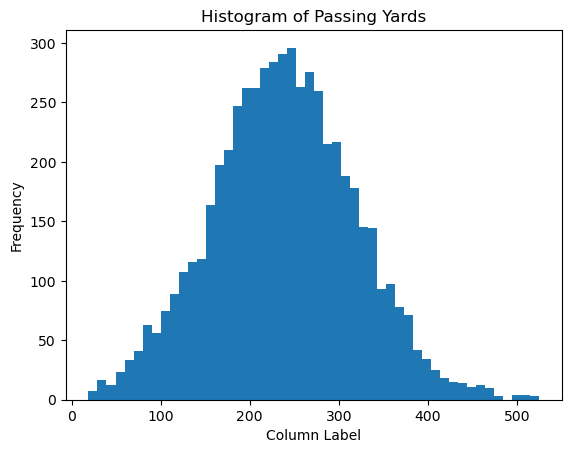

In [78]:
# Identify distribution shape to recreate after we get model results. This looks normal so using our projection for each QB for a week we will use RMSE
# as the standard deviation to create a normal distribution and assign a likelihood to each 
plt.hist(df['passing_yards'], bins=50)  # You can adjust the number of bins
plt.xlabel('Column Label')
plt.ylabel('Frequency')
plt.title('Histogram of Passing Yards')
plt.show()

## Exploratory Data Analysis

In [70]:
# Get an overview of the data
df.describe().round(2)

,season,week,passing_yards,pass_attempts,completion_percentage_ewma_passer,pass_attempts_ewma_passer,air_yards_ewma_passer,yards_after_catch_ewma_passer,epa_ewma_passer,interception_ewma_passer,qb_hit_ewma_passer,sack_ewma_passer,pass_touchdown_ewma_passer,passing_yards_ewma_passer,cpoe_ewma_passer,completion_percentage_ewma_defense,pass_attempts_ewma_defense,air_yards_ewma_defense,yards_after_catch_ewma_defense,epa_ewma_defense,interception_ewma_defense,qb_hit_ewma_defense,sack_ewma_defense,pass_touchdown_ewma_defense,passing_yards_ewma_defense,cpoe_ewma_defense
count,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00,5696.00
mean,2018.64,9.54,237.35,32.24,0.66,31.09,257.37,106.04,0.96,0.73,4.91,2.15,1.43,229.50,0.09,0.66,33.75,280.15,114.73,0.68,0.82,5.38,2.37,1.53,248.06,0.31
std,2.93,5.43,80.93,9.11,0.05,5.90,55.24,27.22,5.02,0.36,1.45,0.78,0.57,51.62,4.84,0.03,2.86,33.55,15.10,3.95,0.32,1.00,0.62,0.39,26.42,3.03
min,2014.00,1.00,14.00,9.00,0.31,8.02,28.75,8.00,-29.73,0.00,0.00,0.00,0.00,24.00,-36.65,0.52,21.00,120.00,45.00,-18.09,0.00,0.00,0.00,0.00,151.00,-11.89
25%,2016.00,5.00,184.00,26.00,0.63,27.90,225.46,89.53,-2.07,0.49,3.96,1.65,1.03,200.63,-2.25,0.64,31.83,257.91,104.33,-1.79,0.59,4.73,1.97,1.27,230.18,-1.57
50%,2019.00,10.00,237.00,32.00,0.66,31.90,261.42,107.32,1.11,0.69,4.84,2.07,1.43,234.23,0.57,0.66,33.61,278.68,113.87,0.74,0.78,5.35,2.34,1.53,247.90,0.42
75%,2021.00,14.00,292.00,38.00,0.69,35.00,293.07,124.02,4.26,0.94,5.80,2.58,1.83,265.55,3.11,0.68,35.53,300.39,124.06,3.23,1.01,6.01,2.77,1.79,265.04,2.31
max,2024.00,22.00,525.00,67.00,0.94,61.00,584.00,238.75,20.92,3.00,17.00,8.00,4.00,448.00,21.86,0.82,61.00,584.00,209.00,20.92,3.00,14.00,5.00,3.10,448.00,16.44


C:\Users\bhugg\AppData\Local\Temp\ipykernel_14948\3032462259.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset_corr = df.corr()


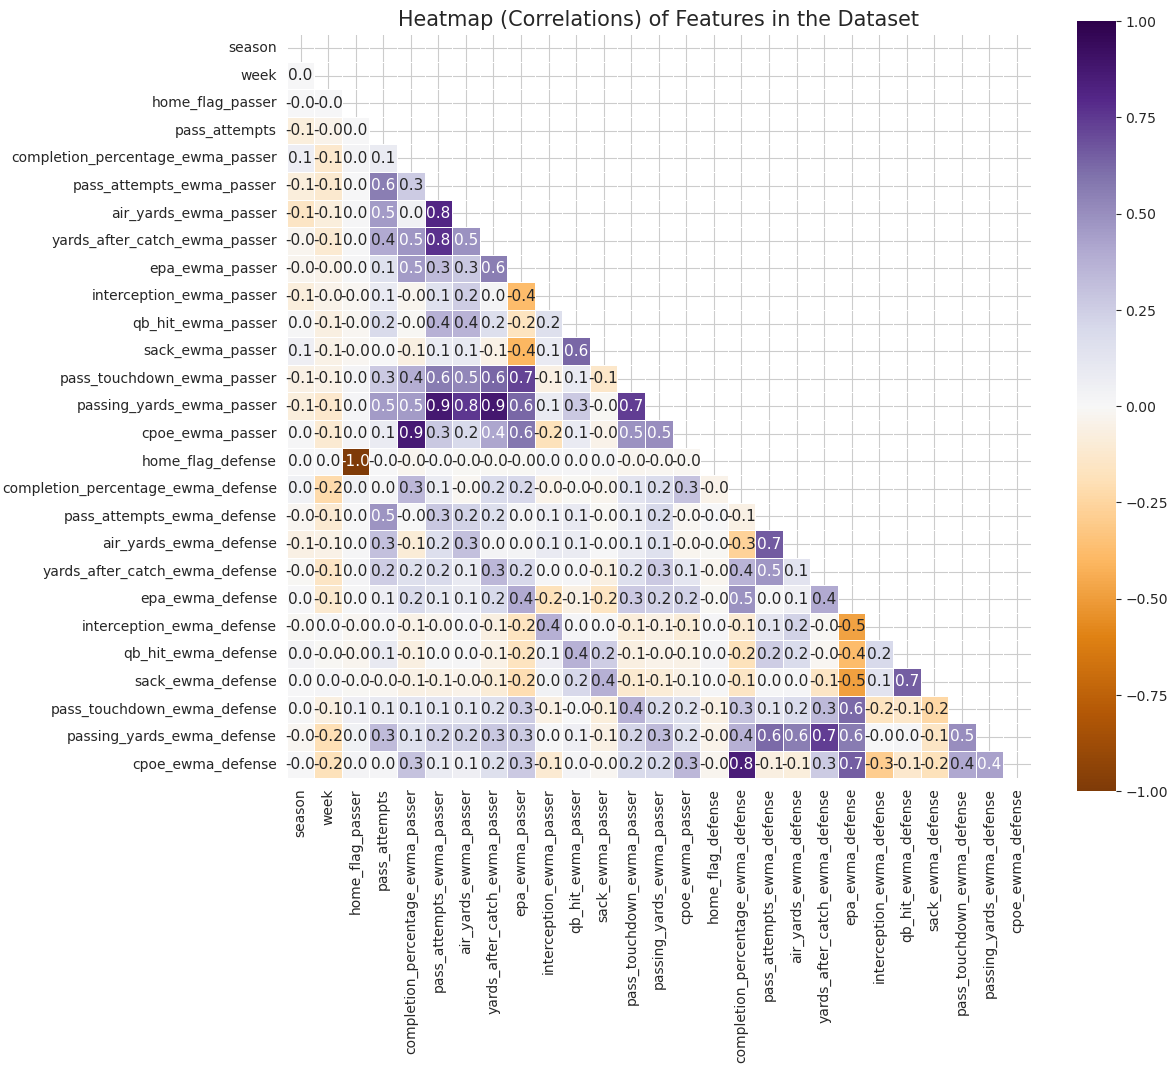

In [79]:
# Create a correlation for the dataset.
dataset_corr = df.corr()

# Drop Agent_ID from correlation dataset.
dataset_corr = dataset_corr.drop(['passing_yards'], axis=1)
dataset_corr = dataset_corr.drop(['passing_yards'], axis=0)

# Create a correlation matrix. Only bottom left corner valued.
mask = np.zeros_like(dataset_corr.round(4))
mask[np.triu_indices_from(mask)] = True

# Generate the corrleation matrix (heatmap) using Seaborn.
with sns.axes_style("whitegrid"):
    f, ax = plt.subplots(figsize=(12, 10))
    ax = sns.heatmap(dataset_corr.round(2), mask=mask, vmax=1, center=0, vmin=-1, square=True,
                     cmap='PuOr', linewidths=.5, annot=True, annot_kws={"size": 11}, fmt='.1f')
    plt.title('Heatmap (Correlations) of Features in the Dataset', fontsize=15)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Features', fontsize=12)
plt.show()

## Modeling w/ Sci-kit Learn

maybe come back to the below cell and figure out how to transform these features into numerical values

In [72]:
# Define the target and features
target = 'passing_yards'
features = df.columns.drop(['passer_player_name', 'passing_yards', 'posteam', 'defteam', 'season', 'week'])

# 'roof', 'surface' need to be OHE 

In [73]:
# Create machine learning df and drop NaN values
ml = df.dropna()

# Define the X and y, leave out 2024 season for testing
X = df.loc[df['season'] != 2024, features].values
y = df.loc[df['season'] != 2024, target].values

In [74]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

In [24]:
# # defining parameters
# params = {
#     'task': 'train',
#     'boosting': 'gbdt',
#     'objective': 'regression',
#     'num_leaves': 10,
#     'learning_rate': 0.01,
#     'metric': {'l2', 'l1'},
#     'verbose': -1,
#     'early_stopping_rounds' : 5
# }

In [75]:

# Define the parameter grid for tuning
param_grid = {
    'num_leaves': [10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.03, 0.05, 0.1],
    'max_depth': [-1, 5, 10, 15],
    'min_data_in_leaf': [10, 20, 30, 50, 100],
    'min_split_gain': [0.0, 0.1, 0.2],
    'subsample_for_bin': [20000, 30000, 40000],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.7, 0.8, 0.9],
    'feature_fraction': [0.7, 0.8, 0.9],
    'lambda_l1': [0, 0.1, 0.5, 1],
    'lambda_l2': [0, 0.1, 0.5, 1],
    'scale_pos_weight': [1, 10, 20],  # for imbalanced datasets
    'objective': ['regression'],
    'boosting_type': ['gbdt', 'dart', 'goss'],  # try different boosting types
    'n_estimators': [500, 1000, 1500],
    'metric': ['rmse']
}

# Instantiate the model
model = lgb.LGBMRegressor(boosting_type='gbdt', random_state=42)

# Set up Bayesian Search
opt = BayesSearchCV(
    estimator=model,
    search_spaces=param_grid,
    n_iter=50,  # More iterations for Bayesian Optimization
    cv=3,
    random_state=42,
    verbose=1,
    n_jobs=-1  # Parallelize the search
)

# Fit the search
opt.fit(X_train, y_train)

# Get the best parameters and test RMSE
best_params = opt.best_params_
y_pred = opt.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'Best Parameters: {best_params}')
print(f'RMSE: {rmse}')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

In [33]:
# Train the model and evaluate with testing data
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

In [35]:
# Fit the model
gbm = lgb.train(best_params, lgb_train, num_boost_round=1000, valid_sets=[lgb_eval])

c:\Users\bhugg\anaconda3\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=0.7 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=0.9 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0009

In [36]:
# prediction
y_pred = gbm.predict(X_test)

# accuracy check
mse = mean_squared_error(y_test, y_pred)
rmse = mse**(0.5)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % rmse)

MSE: 4311.33
RMSE: 65.66


## Making Predictions

In [48]:
twentyfour = df[df['season'] == 2024]


In [51]:
# Ensure y_true and y_pred are 1D arrays
y_true = twentyfour['passing_yards'].values  # Actual values from your dataset
y_pred = model.predict(X_test).flatten()  # Predictions from the fitted model

# Create the residual plot
sns.residplot(x=y_pred, y=y_true)
plt.title('Residual Plot')
plt.xlabel('Predicted Passing Yards')
plt.ylabel('Residuals (Predicted - Actual)')
plt.show()

NotFittedError: Estimator not fitted, call fit before exploiting the model.

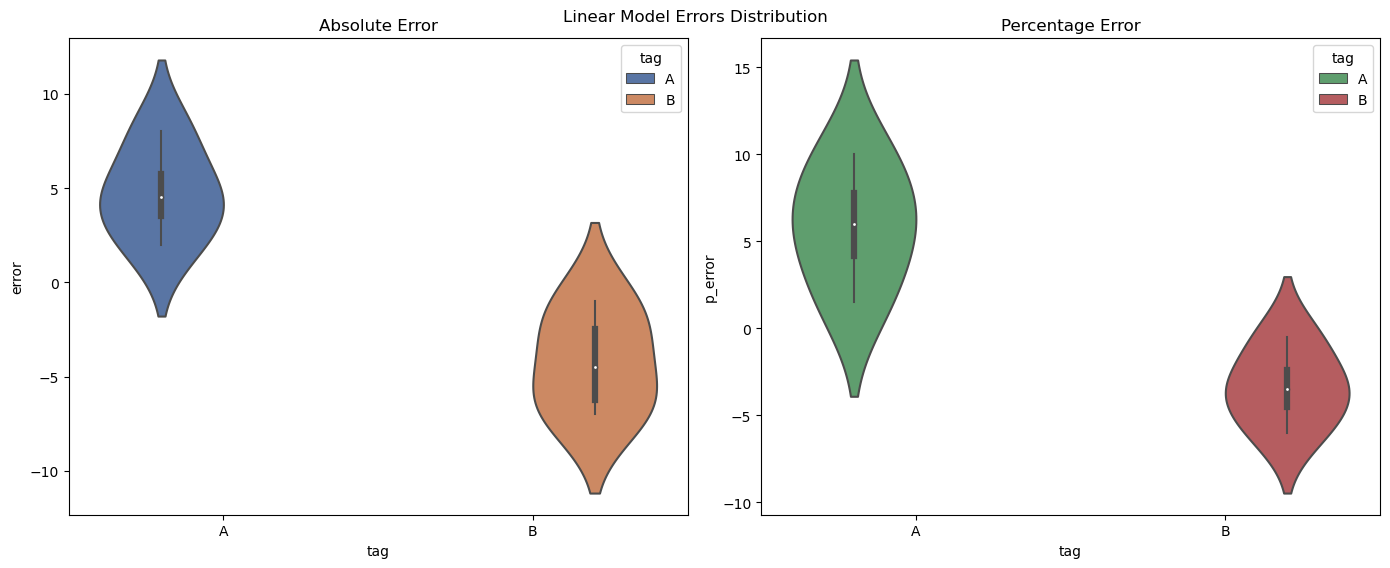

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Simulating example data for y_pred (replace with your actual data)
y_pred = pd.DataFrame({
    'tag': ['A', 'B', 'A', 'B', 'A', 'B', 'A', 'B'],  # Example categories
    'error': [5, -3, 2, -6, 8, -1, 4, -7],  # Absolute error values
    'p_error': [5, -3, 1.5, -4, 10, -0.5, 7, -6]  # Percentage error values
})

# Visualizing in a plot
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

# Creating subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot for absolute errors
sns.violinplot(x='tag', y='error', data=y_pred, hue='tag', palette=[sns_c[0], sns_c[1]], ax=ax[0])
ax[0].set(title='Absolute Error')

# Plot for percentage errors
sns.violinplot(x='tag', y='p_error', data=y_pred, hue='tag', palette=[sns_c[2], sns_c[3]], ax=ax[1])
ax[1].set(title='Percentage Error')

# Adding a title
plt.suptitle(f'Linear Model Errors Distribution', y=0.94)
plt.tight_layout()
plt.show()